<a href="https://colab.research.google.com/github/yoheikikuta/TensorFlow2-check/blob/master/colab/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE with subclassing API

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

In [3]:
tf.__version__

'2.0.0-rc2'

In [0]:
import numpy as np
from tensorflow.keras import layers

In [0]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
z_mean = tf.constant([[1, 2, 3], [10,  20,  30]], dtype=tf.float32)
z_mean

<tf.Tensor: id=0, shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  2.,  3.],
       [10., 20., 30.]], dtype=float32)>

In [7]:
test = Sampling()
inputs = (z_mean, 1.0)
test.call(inputs)

<tf.Tensor: id=21, shape=(2, 3), dtype=float32, numpy=
array([[-3.0921264,  4.5539207,  2.938363 ],
       [ 7.004962 , 15.959758 , 29.527302 ]], dtype=float32)>

In [0]:
class Encoder(layers.Layer):
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z)."""

    def __init__(self,
                latent_dim=32,
                intermediate_dim=64,
                name='encoder',
                **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [0]:
test = Encoder(latent_dim=5)

In [0]:
z_mean, z_log_var, z = test.call(tf.constant([[1.0]], dtype=tf.float32))

In [32]:
z_mean

<tf.Tensor: id=519, shape=(1, 5), dtype=float32, numpy=
array([[-0.11940687,  0.00555659,  0.16622975, -0.14461707, -0.03625527]],
      dtype=float32)>

In [33]:
z_log_var

<tf.Tensor: id=545, shape=(1, 5), dtype=float32, numpy=
array([[-0.15765584,  0.04107405, -0.03509893,  0.02672374, -0.21835668]],
      dtype=float32)>

In [34]:
z

<tf.Tensor: id=566, shape=(1, 5), dtype=float32, numpy=
array([[ 0.22774139, -0.57989913,  0.06180151, -0.50777704,  0.01371183]],
      dtype=float32)>

In [0]:
class Decoder(layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    
    def __init__(self,
                original_dim,
                intermediate_dim=64,
                name='decoder',
                **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation='relu')
        self.dense_output = layers.Dense(original_dim, activation='sigmoid')

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

In [0]:
test = Decoder(original_dim=5)

In [40]:
test.call(tf.constant([[1]], dtype=tf.float32))

<tf.Tensor: id=621, shape=(1, 5), dtype=float32, numpy=
array([[0.5231306 , 0.48356086, 0.50297743, 0.4763574 , 0.51388705]],
      dtype=float32)>

In [0]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self,
                original_dim,
                intermediate_dim=64,
                latent_dim=32,
                name='autoencoder',
                **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim,
                                intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

In [112]:
original_dim = 784
vae = VariationalAutoEncoder(original_dim, 64, 32)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Iterate over epochs.
for epoch in range(20):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            reconstructed = vae(x_batch_train)
            # Compute reconstruction loss
            loss = mse_loss_fn(x_batch_train, reconstructed)
            loss += sum(vae.losses)  # Add KLD regularization loss

        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        loss_metric(loss)

        if step == 0:
            print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
step 0: mean loss = tf.Tensor(0.36238298, shape=(), dtype=float32)
Start of epoch 1
step 0: mean loss = tf.Tensor(0.07488223, shape=(), dtype=float32)
Start of epoch 2
step 0: mean loss = tf.Tensor(0.07125177, shape=(), dtype=float32)
Start of epoch 3
step 0: mean loss = tf.Tensor(0.070005625, shape=(), dtype=float32)
Start of epoch 4
step 0: mean loss = tf.Tensor(0.069374114, shape=(), dtype=float32)
Start of epoch 5
step 0: mean loss = tf.Tensor(0.068986885, shape=(), dtype=float32)
Start of epoch 6
step 0: mean loss = tf.Tensor(0.06872377, shape=(), dtype=float32)
Start of epoch 7
step 0: mean loss = tf.Tensor(0.06853424, shape=(), dtype=float32)
Start of epoch 8
step 0: mean loss = tf.Tensor(0.06839019, shape=(), dtype=float32)
Start of epoch 9
step 0: mean loss = tf.Tensor(0.068276286, shape=(), dtype=float32)
Start of epoch 10
step 0: mean loss = tf.Tensor(0.06818402, shape=(), dtype=float32)
Start of epoch 11
step 0: mean loss = tf.Tensor(0.068106964, shape=(), 

## Reconstruction

In [113]:
reconstructed = vae(x_batch_train)
result = np.array(reconstructed)
result.shape

(32, 784)

In [114]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

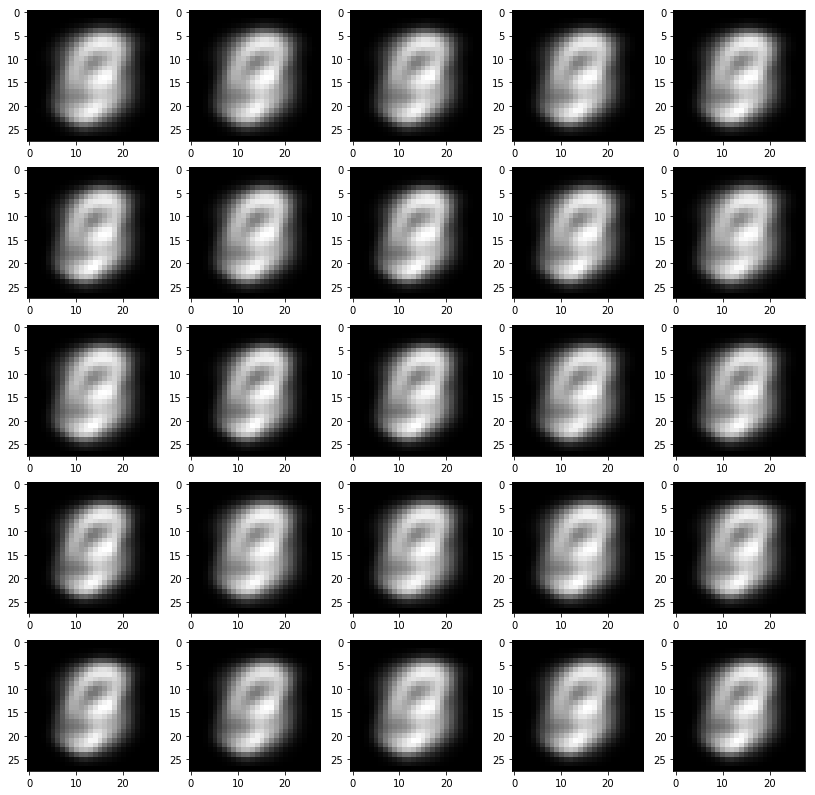

In [115]:
def draw_digit(data, row, col, n):
    # size = 28
    plt.subplot(row, col, n)
    plt.imshow(data)
    plt.gray()

show_size = 5
total = 0
plt.figure(figsize=(14, 14))
for i in range(show_size):
    for j in range(show_size):
        draw_digit(result[total].reshape(28, 28), show_size, show_size, total+1)
        total += 1
plt.show()

NOT WORKING YET...

# Trial and Errors

In [23]:
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

11493376/11490434 [==============================] - 0s 0us/step


In [25]:
x_train.shape

(60000, 784)

In [26]:
train_dataset

<BatchDataset shapes: (None, 784), types: tf.float32>

In [0]:
for elem in train_dataset:
    check = elem
    break

In [59]:
check

<tf.Tensor: id=95, shape=(64, 784), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [0]:
test = VariationalAutoEncoder(original_dim=5)

In [72]:
decoder_loss = test.call(tf.constant([[1]], tf.float32))

ValueError: ignored